In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation

In [2]:
%matplotlib inline

In [47]:
#importing ratings table
r_cols = ['user_id', 'item_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('F:/USF/Spring 2018/independent project/Berndt/Recommendation Systems/ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

In [48]:
#importing movies table
m_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
items = pd.read_csv('F:/USF/Spring 2018/independent project/Berndt/Recommendation Systems/ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')
#items.drop('video_release_date', axis = 1, inplace = True)
items.head()

,item_id,title,release_date,video_release_date,imdb_url
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995)


In [49]:
#importing users table
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('F:/USF/Spring 2018/independent project/Berndt/Recommendation Systems/ml-100k/u.user', sep='|', names=u_cols,
                    encoding='latin-1', parse_dates=True)
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


# REC Data Analysis

As always, our first goal should be to get a better understanding of the data.  The query below uses the main ratings dataframe (ratings) to count users, items and the actual ratings.  We can also count the number of users (users) and movies (items) in the other dataframes, but we are more interested in the participation in the ratings.

In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
user_id           100000 non-null int64
item_id           100000 non-null int64
rating            100000 non-null int64
unix_timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


In [7]:
ratings.head()

,user_id,item_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
df = ratings
df.head()

,user_id,item_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [9]:
#checking distinct values of each column
df[['user_id', 'item_id', 'rating', 'unix_timestamp']].nunique()

user_id             943
item_id            1682
rating                5
unix_timestamp    49282
dtype: int64

No surprises here just the basic tallies expected from the underlying MovieLens(the 100K observation data set was downloaded). The next couple of queries uncover some more interesting data, such as the fact that some users rate hundreds of movies and the minimum number of ratings is 20 (this minimum is based on quality control at MovieLens).

To check how many ratings each user gave with a user giving most ratings first

In [22]:
groupby_user_sorted = df.groupby('user_id').count()['item_id'].reset_index(name='ratings_count').sort_values('ratings_count', ascending = False)
groupby_user_unsorted = df.groupby('user_id').count()['item_id'].reset_index(name='ratings_count')

In [23]:
groupby_user_sorted.head()

,user_id,ratings_count
404,405,737
654,655,685
12,13,636
449,450,540
275,276,518


Below query returns a histogram based on the number of ratings by users, which gives us a much better idea about the distribution of ratings.  There are plenty of users with significant numbers of ratings.

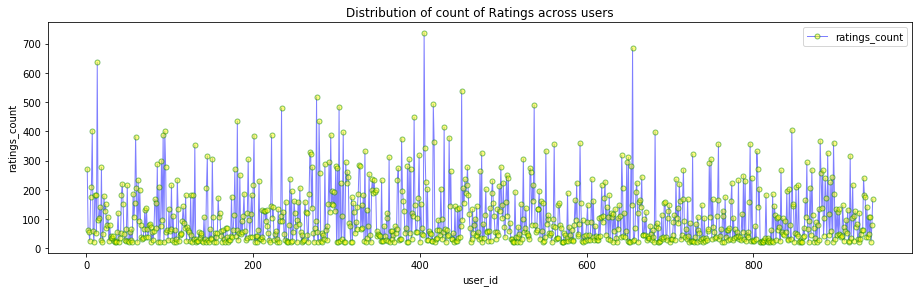

In [25]:
fig = plt.figure(figsize=(15,4))
axes = fig.add_axes([0.1, 0.1, 0.8, 0.8])#left, bottom, width, height
axes.plot(groupby_user_unsorted['user_id'],groupby_user_unsorted['ratings_count'], color = 'blue', linewidth = 1, alpha = 0.5, linestyle = '-', marker='o', markersize = 5,
         markerfacecolor = 'yellow', markeredgewidth = 1, markeredgecolor = 'green')
axes.set_xlabel('user_id')
axes.set_ylabel('ratings_count')
axes.set_title('Distribution of count of Ratings across users')
axes.legend(loc=0)#best location of legend
#fig, axes = plt.subplots(nrows = 1, ncols = 2)
#plt.tight_layout() #fixes overlaps when multiple plots are present
#fig.savefig('ratings count per user.png', dpi = 200)

saves above plot as png onto the present directory

In [26]:
fig.savefig('ratings count per user.png', dpi = 200)

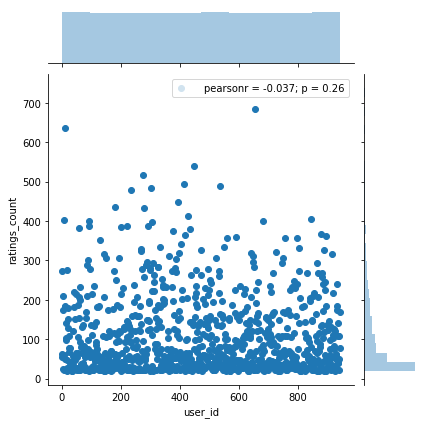

In [28]:
sns.jointplot(x='user_id', y='ratings_count', data = groupby_user_sorted)
#sns.pairplot(groupby_user, hue = 'categorical _variable', palette = 'coolwarm') to plot among different variables in the dataset
#sns.rugplot(groupby_user['count_item_id'])
#sns.distplot(groupby_user['count_item_id'], kde = False, bins = 50)

Of course, we should look at the distribution of ratings by movie items as well.  Here there are some movies with very small numbers of ratings, 
which means the aggregate scores are likely to be somewhat unreliable.  We will need to be careful when making any recommendations with a small number of ratings (or support).


In [30]:
groupby_item = df.groupby('item_id', sort = True).count()['user_id'].reset_index(name='user_count').sort_values('user_count', ascending = False)
groupby_item.head()

,item_id,user_count
49,50,583
257,258,509
99,100,508
180,181,507
293,294,485


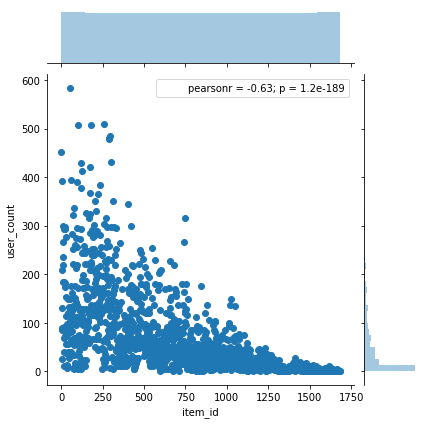

In [31]:
sns.jointplot(x='item_id', y='user_count', data = groupby_item)

First, just look at the average rating on the 1-5 star scale.  Intuitively, you might expect it to be somewhere near the middle (or upper middle range).

In [34]:
round(df['rating'].mean(), 2)

3.53

Now let's look at the distribution of ratings based on the 1-5 star scale.  Note: The middle scores are the most common and the extremes are less common, especially the very low score (1 star).

In [35]:
ratings_count = df.groupby('rating').size().reset_index(name = 'ratings_count').sort_values('rating', ascending = False)
ratings_count.head()

,rating,ratings_count
4,5,21201
3,4,34174
2,3,27145
1,2,11370
0,1,6110


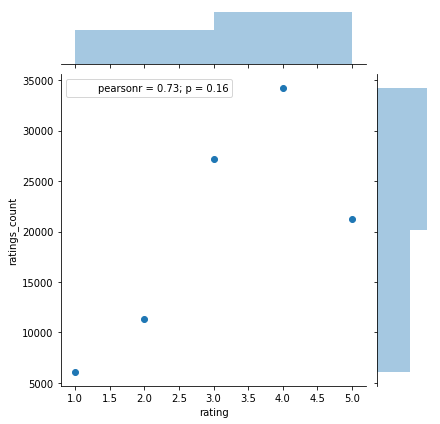

In [36]:
sns.jointplot(x='rating', y='ratings_count', data = ratings_count, kind = 'scatter')

What does the distribution of average ratings (binned at one decimal place) look like by users?

In [43]:
ratings_avg = df.groupby('user_id').mean()['rating'].reset_index(name = 'avg_ratings').sort_values('avg_ratings', ascending = False)
ratings_avg = ratings_avg.round(1)
usercount_peravgrating = ratings_avg.groupby('avg_ratings').count()['user_id'].reset_index(name = 'usercount').sort_values('avg_ratings', ascending = False)
usercount_peravgrating.head()

,avg_ratings,usercount
31,4.9,1
30,4.8,1
29,4.7,4
28,4.6,2
27,4.5,7


What does the distribution of average ratings (binned at one decimal place) look like by movie items?

In [44]:
ratings_avg = df.groupby('item_id').mean()['rating'].reset_index(name = 'avg_ratings').sort_values('avg_ratings', ascending = False)
ratings_avg = ratings_avg.round(1)
itemcount_peravgrating = ratings_avg.groupby('avg_ratings').count()['item_id'].reset_index(name = 'itemcount').sort_values('avg_ratings', ascending = False)
itemcount_peravgrating.head()

,avg_ratings,itemcount
36,5.0,10
35,4.6,1
34,4.5,8
33,4.4,5
32,4.3,18


 Note: For now, we are using the raw ratings, but it would make sense to normalize the ratings since users will have different anchor points.  Creating normalized ratings, such as positive and negative numbers around the user-specific average makes the rating much more comparable.  Let's try that a bit later.

# Global Recommendations

merging datasets

In [51]:
item_ratings = pd.merge(items, ratings)
user_ratings = pd.merge(ratings, users)

In [52]:
item_ratings.head()
#user_ratings.head()

,item_id,title,release_date,video_release_date,imdb_url,user_id,rating,unix_timestamp
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,66,3,883601324


We end this section with a simple global recommendation based only on the average ratings per item.  That is, we use all the user's ratings without considering whether their tastes in movies aligns with our own.  We are careful to make sure there are a reasonable number of ratings to support the recommendation.

In [60]:
avg_ratings_perItem = item_ratings.groupby('title').agg({'rating': [np.mean,np.size]}).round(1)
avg_ratings_perItem = avg_ratings_perItem[avg_ratings_perItem['rating']['size'] >= 10]
AvgRatingsPerMovieWithMinSprt = avg_ratings_perItem.sort_values([('rating', 'mean'), ('rating', 'size')], ascending=False)
AvgRatingsPerMovieWithMinSprt.head()
avg_ratings_perItem.head()

rating     
                                      mean size
title                                          
101 Dalmatians (1996)                  2.9  109
12 Angry Men (1957)                    4.3  125
187 (1997)                             3.0   41
2 Days in the Valley (1996)            3.2   93
20,000 Leagues Under the Sea (1954)    3.5   72

Comment the filter condition(AvgRatingsPerItemMinSprt) out to get the titles of recommendations based on even one rating and contrast that with the list (given at least 10).  I am not sure if I would like the movie "Santa with Muscles" (starring Hulk Hogan), but the list with more stable average ratings seems pretty good.  So, even a simple global recommendation method is a good place to start.  Of course, we could make it even better by just filtering out movies you have already seen (an addition used in later sections).

# REC Collaborative Filtering Recommendations

Collaborative filtering provides a powerful method for generating recommendations, quite different than content-based approaches.  In the case of movie recommendations, collaborative filtering entails finding a subset of cinema fans that have similar tastes (based on movie ratings) and making suggestions from highly rated films.  So, the essential question is how do we measure "similarity" with respect to other movie fans?

While there are several potential similarity measures, here we look at cosine similarity. (or distance), a widely used measure that can be customized for use in specific domains. The basic is formula is quite simple.  In order to apply this formula, we need a bunch of movie ratings by many users (for that we have the MovieLens data) and some ratings of our own.  The Ratings table has 100K ratings that we can use, but we still need to rate some movies of our own.

# Rating Some Movies

I went ahead and rated some movies in order to generate personal recommendations for me.  First, I created a my_movie_ratings dataframe and then inserted some movie ratings using the 1-5 star scale (following the MovieLens convention).  Please feel free to create your own ratings DF based on the code below, so you can refine your own recommendations.

In [61]:
my_movie_ratings = pd.DataFrame(data = [(318, 5), (483, 5), (603, 5), (50, 5), (64, 5), (174, 5), (357, 5), (272, 4), (127, 4), 
                        (480, 5), (657, 4), (498, 5), (22, 4), (313, 3), (302, 4)], columns = ['item_id', 'rating'])
my_movie_ratings.head()

,item_id,rating
0,318,5
1,483,5
2,603,5
3,50,5
4,64,5


It is a good time to review my own movie ratings.  I will need to come back to this and rate more movies (with a wider range), but we can use this short list for now.  The movie titles are included so you can judge my ratings and perhaps generate your own.

In [62]:
my_ratings = pd.merge(my_movie_ratings, items[['item_id', 'title']], on='item_id')

In [63]:
my_ratings.head()

,item_id,rating,title
0,318,5,Schindler's List (1993)
1,483,5,Casablanca (1942)
2,603,5,Rear Window (1954)
3,50,5,Star Wars (1977)
4,64,5,"Shawshank Redemption, The (1994)"


# Cosine Similarity

Let's start this section by writing some simple queries that compute the intermediate results necessary for the cosine similarity formula.  First, we simply square the rating vectors for all users.  We then need to do the same to our own ratings for normalizing the similarity measure.

In [65]:
ratings1 = ratings
ratings1['norm'] = ratings['rating'].apply(lambda o: o * o)

In [66]:
ratings1.head()

,user_id,item_id,rating,unix_timestamp,norm
0,196,242,3,881250949,9
1,186,302,3,891717742,9
2,22,377,1,878887116,1
3,244,51,2,880606923,4
4,166,346,1,886397596,1


In [68]:
ratings1_sum = ratings1.groupby('user_id').agg({'norm': [np.sum]})

In [70]:
#creating my ratings DF with sum of squared distances between ratings given by me
my_ratings1 = my_ratings
my_ratings1['norm'] = my_ratings1['rating'].apply(lambda o: o * o)
my_ratings_squared_sum = my_ratings1.agg({'norm': [np.sum]})

In [71]:
my_ratings_squared_sum.head()

,norm
sum,314


similarly we're creating sum of squared distances between ratings given by other users

In [84]:
#getting squared ratings in ratings DF
ratings1['norm'] = ratings['rating'].apply(lambda o: o * o)
user_ratingSquared = ratings1.groupby('user_id').sum()['norm'].reset_index(name = 'norm')
user_ratingSquared.head()

,user_id,norm
0,1,3978
1,2,918
2,3,501
3,4,470
4,5,1769


Now we will compute the distance between our ratings and those of other users.

In [83]:
#creating distances DF which has distance between our ratings and other users 
join = pd.merge(ratings, my_ratings, on='item_id')
join['dist'] = join.apply(lambda o: (o['rating_x'] * o['rating_y']), axis = 1)
distances = join.groupby('user_id').sum()['dist'].reset_index(name = 'dist')
distances.head()

,user_id,dist
0,1,123
1,2,100
2,3,36
3,4,45
4,5,45


Now we'll join the distances, user ratings and cross join with the my_ratings dataframe to apply the cosine similarity method

In [85]:
distances['key'] = 0
my_ratings_squared_sum['key'] = 0
x = pd.merge(pd.merge(distances, user_ratingSquared, on='user_id'), my_ratings_squared_sum, on='key')
del x['key']

In [86]:
x.head()

,user_id,dist,norm_x,norm_y
0,1,123,3978,314
1,2,100,918,314
2,3,36,501,314
3,4,45,470,314
4,5,45,1769,314


In [87]:
#creating a similarityDF with cosine similarity values calculated per user to measure the strength of similarity from me and other users
x['norm_x_sqrt'] = x['norm_x'].pow(1./2)
x['norm_y_sqrt'] = x['norm_y'].pow(1./2)
x['dist_sqrt'] = x.apply(lambda o: (o['norm_x_sqrt'] * o['norm_y_sqrt']), axis = 1)
x['score'] = x.apply(lambda o: (o['dist'] / o['dist_sqrt']), axis = 1)
similarityDF = x[['user_id', 'score']].sort_values('score', ascending = False)
#distances = join.groupby('user_id').sum()['dist'].reset_index(name = 'dist')
#distances.head()

In [88]:
similarityDF.head()

,user_id,score
687,744,0.385513
81,91,0.379888
361,397,0.359192
620,669,0.355183
627,676,0.354151


Now, compare my ratings (and yours once you create your own table) to some specific users that are found to be somewhat similar (like user 744).  Try some others to verify that the ratings vector looks similar.

In [93]:
compare_my_ratings = pd.merge(pd.merge(ratings1, my_ratings, on='item_id'), items, on='item_id')
compare_my_ratings = compare_my_ratings.rename(columns={'rating_x': 'user_rating', 'rating_y': 'my_rating', 'title_x': 'movie_title'})
compare_my_ratings1 = compare_my_ratings.loc[compare_my_ratings['user_id'] == 744]
compare_my_ratings_with_user_744 = compare_my_ratings1[['item_id', 'my_rating', 'user_rating', 'movie_title']].sort_values('item_id')
compare_my_ratings_with_user_744.head()

,item_id,my_rating,user_rating,movie_title
3310,50,5,3,Star Wars (1977)
1887,127,4,5,"Godfather, The (1972)"
1206,174,5,4,Raiders of the Lost Ark (1981)
202,302,4,5,L.A. Confidential (1997)
1688,483,5,4,Casablanca (1942)


# Generating Some Recommendations

In order to generate some recommendations, we will need to create a list of similar users for collaborative filtering.  First, we create the DataFrame and then populate it with a list of users based on our cosine similarity measure.

In [94]:
similar_users = pd.DataFrame(columns=['user_id', 'score'])

Note: We choose the 30 most similar users.  It makes sense to experiment with this number.  We want to be selective enough to make the recommendations unique to our tastes.  Obviously, the larger the number, the more we approximate a global recommendation.You should try creating your own ratings and list of similar users.

In [95]:
similar_users = similarityDF.head(30)

In [96]:
similar_users.head()

,user_id,score
687,744,0.385513
81,91,0.379888
361,397,0.359192
620,669,0.355183
627,676,0.354151


In [98]:
#Merging the similar users DF we just created to the user ratings DF to get the ratings given by other users similar to the above users
x = pd.merge(pd.merge(similar_users, ratings, on='user_id'), items, on='item_id')

In [99]:
#Here I removed the movies that I rated as it indicates I already watched them
x1 = x[~x.item_id.isin(my_movie_ratings.item_id)]
x1.head()

,user_id,score,item_id,rating,unix_timestamp,norm,title,release_date,video_release_date,imdb_url
43,744,0.385513,237,4,881171907,16,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...
44,494,0.317293,237,4,879541375,16,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...
45,913,0.314807,237,4,881725960,16,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...
46,391,0.303740,237,4,877399864,16,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...
47,263,0.300239,237,2,891300103,4,Jerry Maguire (1996),13-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Jerry%20Magui...


In [102]:
#here I create a variable called 'score' which tells the avg rating that each movie has got (similar to avg rating per movie) 
#I only considered movies that has got atleast 10 ratings to get more support to our recommendations
x2 = x1.groupby('title').agg({'rating': 'sum', 'item_id': 'count'}).reset_index().rename(columns = {'rating':'sum_ratings', 'item_id':'count_items'})
x2['score'] = x2.apply(lambda o: (round((o['sum_ratings']/float(o['count_items'])), 1)), axis = 1)
x3 = x2[x2['count_items']>10]
x4 = x3[['title', 'score', 'count_items']].sort_values('score', ascending = False).head(10)
x4.head()

,title,score,count_items
186,Fargo (1996),4.5,14
356,Monty Python and the Holy Grail (1974),4.5,13
566,"Usual Suspects, The (1995)",4.4,12
111,Citizen Kane (1941),4.4,14
5,2001: A Space Odyssey (1968),4.3,12


# SEC Normalized Ratings

We have implemented a basic collaborative filtering approach to making movie recommendations based on cosine similarity.  However, we used the ratings data "as is" without applying any transformations. Of course, the ratings data is underlying all the recommendations. Can we improve things a bit?

In [103]:
avg_rating_per_user = ratings.groupby('user_id').agg({'rating': 'mean', 'item_id': 'count'}).reset_index().rename(columns = {'rating': 'avg_rating', 'item_id':'count_items'})
avg_rating_per_user['avg_rating'] = avg_rating_per_user['avg_rating'].round(1)
avg_rating_per_user.head()

,user_id,count_items,avg_rating
0,1,272,3.6
1,2,62,3.7
2,3,54,2.8
3,4,24,4.3
4,5,175,2.9


In [122]:
my_ratings['avg_ratings'] = my_ratings['rating'].mean()
my_ratings['norm_rating'] = my_ratings['rating'] - modified_ratings['avg_rating']
my_avg_ratings = my_ratings
my_avg_ratings.head()

,item_id,rating,title,norm,avg_ratings,norm_rating
0,318,5,Schindler's List (1993),25,4.533333,1.4
1,483,5,Casablanca (1942),25,4.533333,1.4
2,603,5,Rear Window (1954),25,4.533333,1.4
3,50,5,Star Wars (1977),25,4.533333,1.4
4,64,5,"Shawshank Redemption, The (1994)",25,4.533333,1.4


The query above investigates the average rating by user and also includes the number of ratings. Recall that the MovieLens data includes only users that have at least 20 movie ratings.  However, it is highly likely that everyone has a different perspective on assigning ratings. What numeric rating means an average movie to a user? The way each user assigns ratings is somewhat unique. The screen shot below shows some of the data by user. How can we normalize the ratings data to make the observations more comparable?

# Normalizing the Ratings Data

The most important transformation is to "center" the ratings for each user.  This makes the actual numeric less important and allows us to better compare across users.  The query below creates a table with with transformed ratings.  Create your own dataframe and have a look.  Feel free to add in other approaches.

In [104]:
modified_ratings = pd.merge(avg_rating_per_user, ratings, on='user_id')

In [105]:
modified_ratings['norm_rating'] = modified_ratings['rating'] - modified_ratings['avg_rating']

In [106]:
normalized_Ratings = modified_ratings[['user_id', 'item_id', 'rating', 'norm_rating', 'unix_timestamp']]
normalized_Ratings.head()

,user_id,item_id,rating,norm_rating,unix_timestamp
0,1,61,4,0.4,878542420
1,1,189,3,-0.6,888732928
2,1,33,4,0.4,878542699
3,1,160,4,0.4,875072547
4,1,20,4,0.4,887431883


As an exercise, go back and modify the Python-based recommender system to use these new normalized ratings.  Do the recommendations change?  Are the recommendations better in some sense?